<a href="https://colab.research.google.com/github/simjeongho/XceptionV2/blob/main/diagnosis_Atopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
# torch import

파이토치 import 

Xception 모듈의 기본적인 아이디어는 Depthwise Separable Convolution

**Depthwise convolution** : input의 각각의 channel에 대해서 독립적으로 수행하는 convolution이다. 

**PointWise Convolution** : depthwise convolution에 의해 연산된 output을 새로운 channel space로 projecting하는 방법이다. 
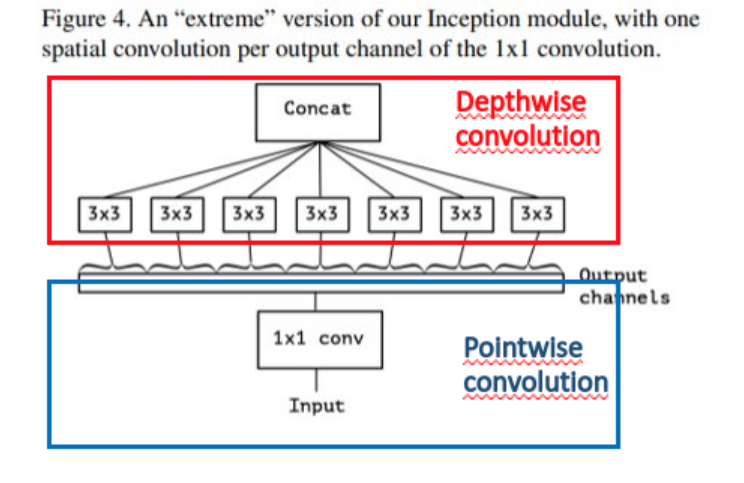

In [ ]:
#
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(SeparableConv2d, self).__init__()

        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
        ) #ReLu함수가 들어간다. 변경 가능점 1
        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

Xception Architecture
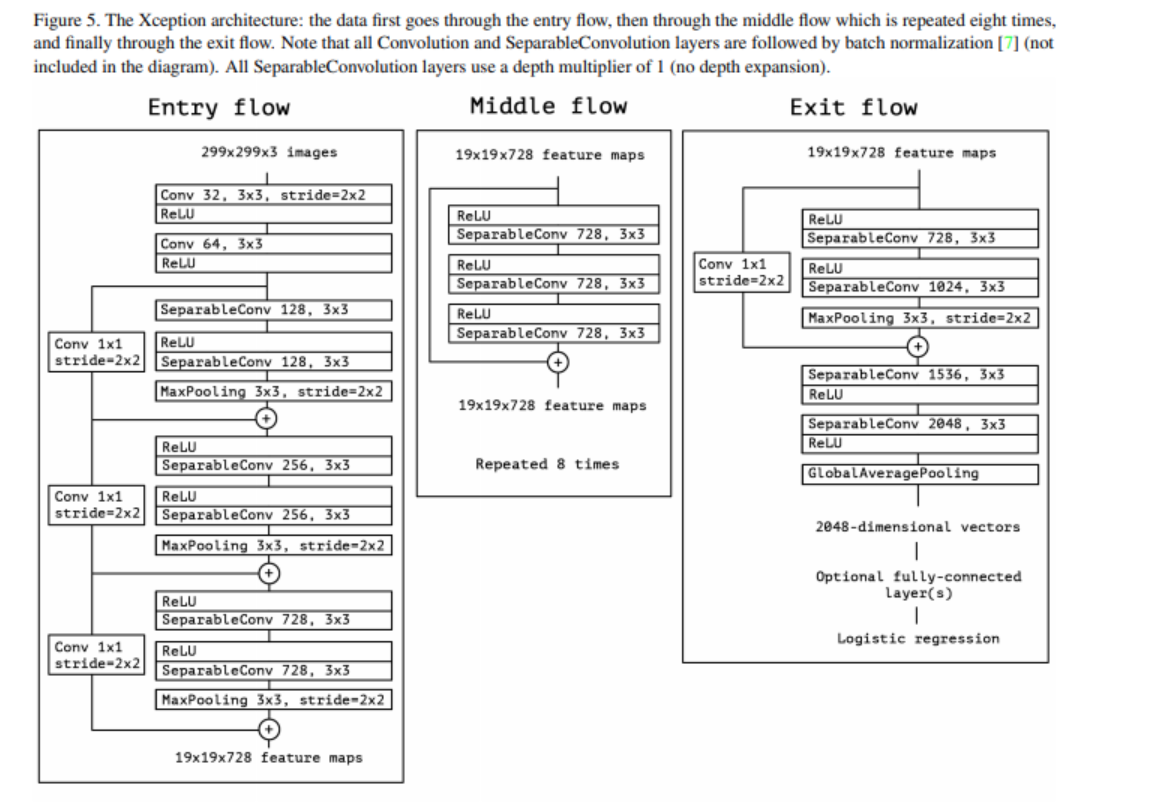

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels):
        super(Block, self).__init__()
        self.feature = nn.Sequential(
            nn.ReLU(),
            SeparableConv2d(in_channels, in_channels, kernel_size=3),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            SeparableConv2d(in_channels, in_channels, 3),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            SeparableConv2d(in_channels, in_channels, 3),
            nn.BatchNorm2d(in_channels),  
        )

    def forward(self, x):
        x = self.feature(x) + x
        x = self.feature(x) + x
        x = self.feature(x) + x
        x = self.feature(x) + x
        x = self.feature(x) + x
        x = self.feature(x) + x
        x = self.feature(x) + x
        x = self.feature(x) + x
        return x
        


`conv2D함수` : `torch.nn.Conv2d`(
    in_channels, 
    out_channels, 
    kernel_size, 
    stride=1, 
    padding=0, 
    dilation=1, 
    groups=1, 
    bias=True, 
    padding_mode='zeros'
)

In [ ]:
class Xception(nn.Module):
    def __init__(self):
        super(Xception, self).__init__()
        self.feature = nn.Sequential(
            # 3차원 이미지 -> 32차원 
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.conv3 = nn.Conv2d(64, 128, kernel_size=1, stride=2)

        self.block1 = nn.Sequential(
            SeparableConv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            SeparableConv2d(128, 128, 3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv4 = nn.Conv2d(128, 256, kernel_size=1, stride=2)

        self.block2 = nn.Sequential(
            nn.ReLU(),
            SeparableConv2d(128, 256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            SeparableConv2d(256, 256, 3),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv5 = nn.Conv2d(256, 728, kernel_size=1, stride=2)

        self.block3 = nn.Sequential(
            nn.ReLU(),
            SeparableConv2d(256, 728, kernel_size=3),
            nn.BatchNorm2d(728),
            nn.ReLU(),
            SeparableConv2d(728, 728, 3),
            nn.BatchNorm2d(728),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        #self.conv6 = nn.Conv2d(728, 728, kernel_size=1, stride=2)

        self.block4 = Block(728)

        self.conv7 = nn.Conv2d(728, 1024, kernel_size=1, stride=2)

        self.block5 = nn.Sequential(
            nn.ReLU(),
            SeparableConv2d(728, 728, kernel_size=3),
            nn.BatchNorm2d(728),
            nn.ReLU(),
            SeparableConv2d(728, 1024, 3),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)   
        )

        self.block6 = nn.Sequential(
            nn.ReLU(),
            SeparableConv2d(1024, 1536, kernel_size=3),
            nn.BatchNorm2d(1536),
            nn.ReLU(),
            SeparableConv2d(1536, 2048, 3),
            nn.BatchNorm2d(2048),
            nn.AvgPool2d(kernel_size=2, stride=1)
        )

        self.fc = nn.Linear(2048, 100)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
